# Relax Inc. Take-Home Chalenge

Relax Inc. is a highly funded startup based in San Francisco that makes productivity and project management software that's extremely popular with both individuals and teams. Founded in 2008 by several ex-Facebook employees, it's considered one of the sexiest companies to work for.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

## Load and Clean the data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
#load engagement data
engagement = pd.read_csv('data/takehome_user_engagement.csv')
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
#create new column with just dates
engagement['date'] = engagement['time_stamp'].dt.date
engagement.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [4]:
#total engagements
len(engagement)

207917

In [5]:
#check if user logged in to the product on the same day
sum(engagement.groupby('user_id')['date'].value_counts() > 1)

0

In [6]:
#create a new dataframe which includes all dates for each user
#set user_id and date as index only including visited as data
s = engagement.set_index(['user_id', 'date'], append=True).visited
#groupby and count
s = s.groupby(level=['user_id','date']).count()
#unstack user_id and then transpose
d = s.unstack('date', fill_value=0).T
#create an index from start of data to end of data
tidx = pd.date_range(min(engagement['date']), max(engagement['date']))
#conform dataframe to new index
d = d.reindex(tidx, fill_value=0)
#create a series from the dataframe
d1 = d.rolling('1D').sum().resample('1D').first().astype(d.dtypes).stack(0)
d1 = d1.rename_axis(['date', 'user_id'])

In [7]:
#put d1 to dataframe
d2 = pd.DataFrame(d1)
#rename column
d2 = d2.rename(columns={0:'visited'})
#set index
d2 = d2.reset_index()
#sort according to user id and date
d2 = d2.sort_values(['user_id', 'date'])

In [8]:
#qualify "adopted users"
d2['adopted'] = d2['visited'].rolling(7, min_periods=3).sum()
adopted = d2[d2['adopted'] >= 3]

In [9]:
#create a list of adopted users
adopted = list(adopted['user_id'].unique())
#frequency visits
freq = engagement.groupby('user_id')['visited'].sum().reset_index(name='freq')

In [10]:
#load users data
users = pd.read_csv('data/takehome_users.csv')
#rename column
users = users.rename(columns={'object_id':'user_id'})
#merge freq to dataframe
users = users.merge(freq, how='outer', on='user_id')
#assign 1 for adopted
users['adopted'] = [1 if x in adopted else 0 for x in users['user_id']]

In [11]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,freq,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0


In [12]:
#turn dates to dates
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
#length in the platform
users['length'] = users['last_session_creation_time'] - users['creation_time']
#fill null length values
users['length'].fillna(0, inplace=True)
#convert to data to integer
users['length'] = users['length'].astype('timedelta64[D]').astype(int)

In [13]:
#deal with null values
users['invited_by_user_id'].fillna(0, inplace=True)
users['freq'].fillna(0, inplace=True)
users['last_session_creation_time'].fillna(users['creation_time'], inplace=True)

In [14]:
#lower string all
users['creation_source'] = users['creation_source'].str.lower()

In [15]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,freq,adopted,length
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,guest_invite,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,org_invite,2014-03-31 03:45:04,0,0,1,316.0,14.0,1,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,org_invite,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,guest_invite,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,guest_invite,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0,5


In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 13 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
freq                          12000 non-null float64
adopted                       12000 non-null int64
length                        12000 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(6), object(3)
memory usage: 1.6+ MB


## EDA and Visualizations

While it does look like that their is a correlation between org_id and adopted user, it is not simply the case as org ids are basically categorical data. It is possible that later registered organizations are more active in the app. That also means that invited by users should also be treated the same way.

In [17]:
#where are the users coming from?
cs = users.groupby('creation_source')['creation_source'].count().sort_values(ascending=False).reset_index(name='counts')

In [18]:
cs

,creation_source,counts
0,org_invite,4254
1,guest_invite,2163
2,personal_projects,2111
3,signup,2087
4,signup_google_auth,1385


In [19]:
#separate the users adopted vs non-adopted
users1 = users[users['adopted']==1]
users0 = users[users['adopted']==0]

In [20]:
#number of adopted users, and percentage
len(users1), round(len(users1)/float(len(users)) * 100, 2)

(1849, 15.41)

In [21]:
#create a cities dataframe to plot retained vs non-retained users
cs1 = users1.groupby('creation_source')['creation_source'].count().sort_values(ascending=False).reset_index(name='counts')
cs1['adopted'] = 'Yes'
cs0 = users0.groupby('creation_source')['creation_source'].count().sort_values(ascending=False).reset_index(name='counts')
cs0['adopted'] = 'No'
cses = [cs1, cs0]
cses = pd.concat(cses).reset_index(drop=True)

,creation_source,counts,adopted
0,org_invite,630,Yes
1,guest_invite,412,Yes
2,signup,350,Yes
3,signup_google_auth,276,Yes
4,personal_projects,181,Yes
5,org_invite,3624,No
6,personal_projects,1930,No
7,guest_invite,1751,No
8,signup,1737,No
9,signup_google_auth,1109,No


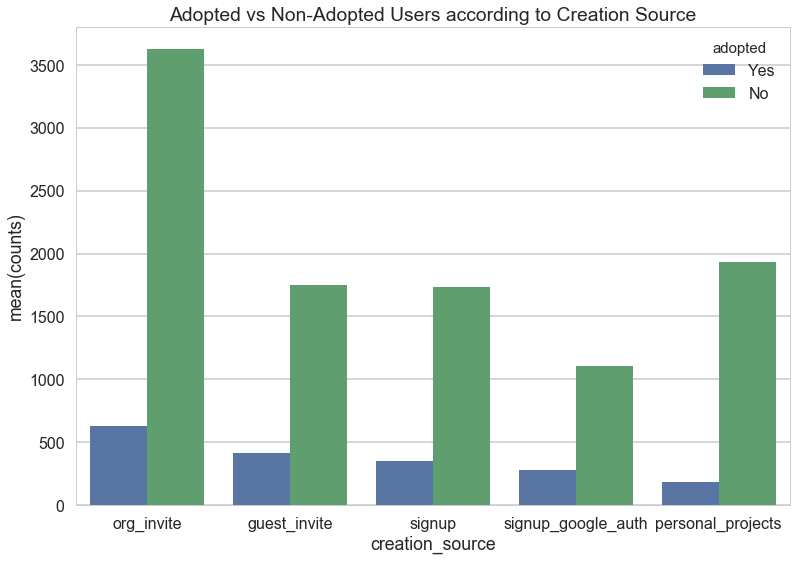

In [22]:
#plot retained vs non-retained users
sns.barplot(x=cses['creation_source'], y=cses['counts'], hue=cses['adopted'])
plt.title('Adopted vs Non-Adopted Users according to Creation Source')
cses

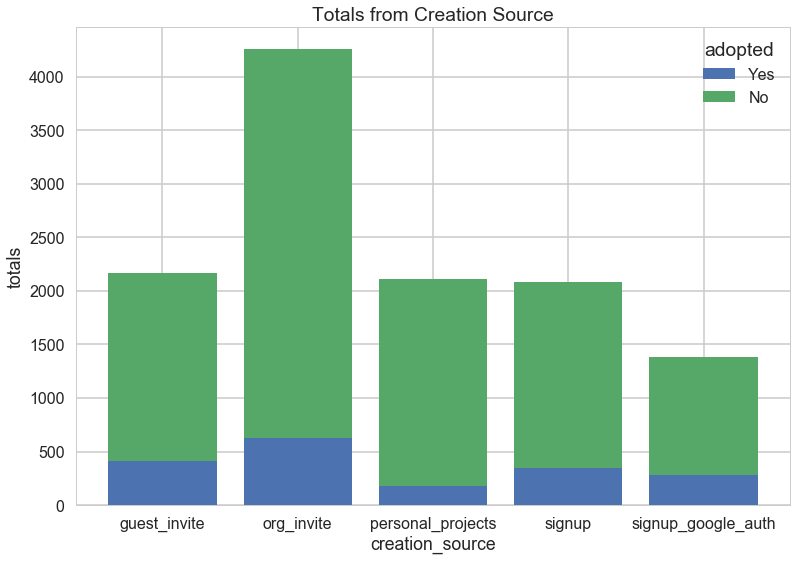

In [23]:
#create dataframe for stacked bar plot
css = users.groupby(['creation_source','adopted'])['adopted'].size().unstack('adopted')
css = css.rename(columns={0:'no', 1:'yes'})
css = css.reset_index()

#creat the plots
p1 = plt.bar(css['creation_source'], css['yes'])
p2 = plt.bar(css['creation_source'], css['no'],
             bottom= css['yes'])

#put proper labels
plt.xlabel('creation_source')
plt.ylabel('totals')
plt.xticks(css['creation_source'] )
plt.title('Totals from Creation Source')
plt.legend((p1[0], p2[0]), ('Yes', 'No'), title='adopted')

plt.show()

While the largest source of new users is the org invites, it is also seems the least effective in creating adopted users.

In [24]:
#how many organizations are in the data
len(users['org_id'].unique())

417

In [25]:
#which organizations are the largest?
users.groupby('org_id')['user_id'].count().sort_values(ascending=False).reset_index(name='counts').head(10)

,org_id,counts
0,0,319
1,1,233
2,2,201
3,3,168
4,4,159
5,6,138
6,5,128
7,9,124
8,7,119
9,10,104


Unsurprisingly, the largest organizations are the first ones assuming the org ids are assigned in order that an organization is created.

In [26]:
#are they also the biggest source of org invites?
(users[users['creation_source']=='org_invite']
 .groupby('org_id')['user_id'].count().sort_values(ascending=False)
 .reset_index(name='counts').head(20))

,org_id,counts
0,0,104
1,1,81
2,3,70
3,2,68
4,6,62
5,4,57
6,9,54
7,5,44
8,7,36
9,11,33


It does seem that the newer organizations are gaining on the older ones but the older ones are still tbe biggest source of org invites.

In [27]:
#who invited the most?
invites = users.groupby('invited_by_user_id')['user_id'].count().sort_values(ascending=False).reset_index(name='invites')
invites = invites.rename(columns={'invited_by_user_id':'user_id'})
invites.head(11)

,user_id,invites
0,0.0,5583
1,10741.0,13
2,2527.0,12
3,1525.0,11
4,11770.0,11
5,2308.0,11
6,1175.0,10
7,2354.0,10
8,8068.0,10
9,6370.0,10


From this data, we can say that the new users seem to invite the most. This is additional data that can be paired to the users dataframe.

In [28]:
#this data will be added to the users dataframe
users = users.merge(invites, how='left', on='user_id')
users['invites'].fillna(0, inplace=True)

In [29]:
users.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,freq,adopted,length,invites
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,141.884583,3188.691333,17.326417,0.154083,43.543083,0.534750
std,0.432742,0.356432,124.056723,3869.027693,64.287839,0.361044,126.352426,1.350473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,108.000000,875.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,238.250000,6317.000000,1.000000,0.000000,3.000000,0.000000
max,1.000000,1.000000,416.000000,11999.000000,606.000000,1.000000,729.000000,13.000000


In [30]:
#dataframes to compare adopted and non-adopted user
users1 = users[users['adopted']==1]
users0 = users[users['adopted']==0]

In [31]:
#statistics of adopted users
users1.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,freq,adopted,length,invites
count,1849.000000,1849.000000,1849.000000,1849.000000,1849.000000,1849.0,1849.000000,1849.000000
mean,0.254191,0.155760,160.404002,3362.301785,107.228772,1.0,261.021092,0.640887
std,0.435524,0.362726,124.027841,3878.642699,131.402776,0.0,216.079849,1.475549
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000
25%,0.000000,0.000000,49.000000,0.000000,11.000000,1.0,79.000000,0.000000
50%,0.000000,0.000000,138.000000,1484.000000,46.000000,1.0,215.000000,0.000000
75%,1.000000,0.000000,261.000000,6590.000000,160.000000,1.0,419.000000,1.000000
max,1.000000,1.000000,415.000000,11994.000000,606.000000,1.0,729.000000,11.000000


In [32]:
#statistics of non-adopted users
users0.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,freq,adopted,length,invites
count,10151.000000,10151.000000,10151.000000,10151.000000,10151.000000,10151.0,10151.000000,10151.000000
mean,0.248645,0.148163,138.511280,3157.068269,0.950744,0.0,3.929564,0.515417
std,0.432249,0.355279,123.770083,3866.625961,1.239791,0.0,13.675993,1.325585
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,26.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,103.000000,734.000000,1.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,234.000000,6304.000000,1.000000,0.0,1.000000,0.000000
max,1.000000,1.000000,416.000000,11999.000000,20.000000,0.0,251.000000,13.000000


The statistics just confirms that adopted users are more involved with the platform. This is evident in the length (days since account creation), frequency(user logins) and invites(invites to the platform). Correllations can be seen on the heatmap below.

Text(0.5,1,u'Correlation Matrix')

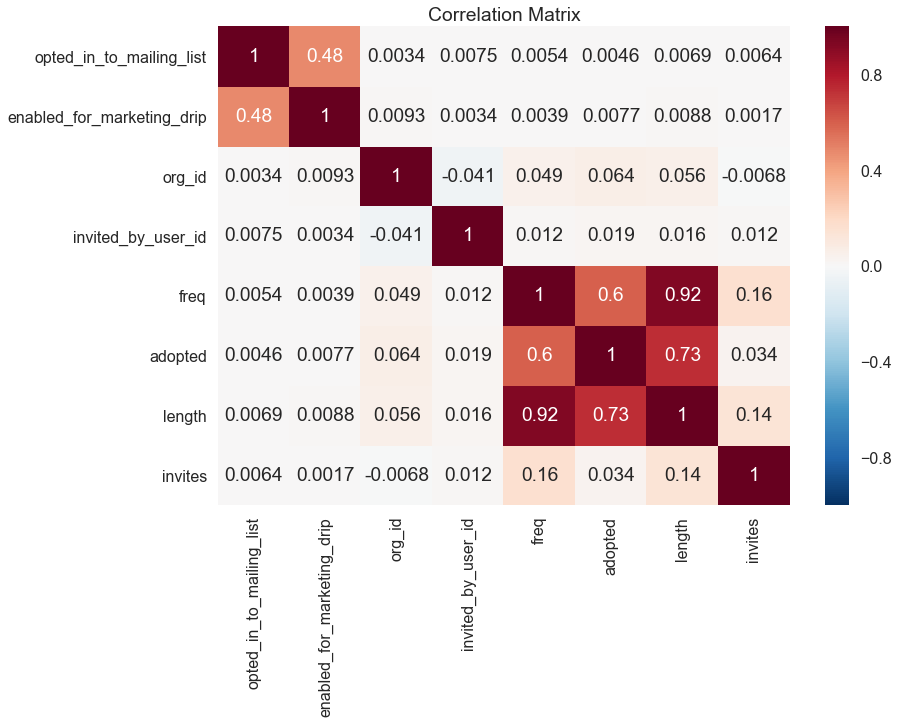

In [33]:
sns.heatmap(users.corr(), annot=True)
plt.title('Correlation Matrix')

## Building a Predicitve Model for User Adoption

In [34]:
#create a dataframe to 
ml_data = users[['adopted',
                'invites', 'length', 'freq',
                'creation_source', 'org_id', 'invited_by_user_id',
                #'opted_in_to_mailing_list', 'enabled_for_marketing_drip'
                ]]

In [35]:
ml_data = pd.get_dummies(ml_data, columns=ml_data[['creation_source', 'org_id', 'invited_by_user_id']])
ml_data.head(2)

,adopted,invites,length,freq,creation_source_guest_invite,creation_source_org_invite,creation_source_personal_projects,creation_source_signup,creation_source_signup_google_auth,org_id_0,...,invited_by_user_id_11966.0,invited_by_user_id_11972.0,invited_by_user_id_11973.0,invited_by_user_id_11974.0,invited_by_user_id_11978.0,invited_by_user_id_11981.0,invited_by_user_id_11986.0,invited_by_user_id_11994.0,invited_by_user_id_11997.0,invited_by_user_id_11999.0
0,0,0.0,0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,136,14.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
from sklearn.model_selection import train_test_split

In [37]:
#split the data to train and test data
X_train, X_test, y_train, y_test = train_test_split(ml_data.loc[:, 'invites':], ml_data['adopted'],
                                                    test_size=0.20,
                                                    random_state=5)

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
clf = LogisticRegression(random_state=1)

In [40]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
clf.score(X_train, y_train)

0.97083333333333333

In [42]:
clf.score(X_test, y_test)

0.96666666666666667

In [43]:
#score our model
from sklearn.metrics import recall_score, f1_score, precision_score

In [44]:
#A low precision means a large number of false positives
precision_score(y_test, clf.predict(X_test))

0.970873786407767

In [45]:
#A low recall means a large number of false negatives
recall_score(y_test, clf.predict(X_test))

0.80862533692722371

In [46]:
#f1 score is the weighted average of the precision and recall
f1_score(y_test, clf.predict(X_test))

0.88235294117647067

By playing around with the features of the predictive model, we are able to determine that the best predictors of user adoption is frequency of visits and length in it.

The model has a good acuracy on the test data at close to 97% and an f1 score of 88%.

### Fine-Tuning The Model

In [48]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
from sklearn.grid_search import GridSearchCV

param = {"C" : Cs}
grid_search = GridSearchCV(clf, param_grid=param, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)
grid_search.grid_scores_, grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

([mean: 0.95896, std: 0.00358, params: {'C': 0.001},
  mean: 0.96458, std: 0.00073, params: {'C': 0.01},
  mean: 0.96552, std: 0.00142, params: {'C': 0.1},
  mean: 0.96573, std: 0.00175, params: {'C': 1},
  mean: 0.96333, std: 0.00191, params: {'C': 10},
  mean: 0.95781, std: 0.00337, params: {'C': 100}],
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'C': 1},
 0.9657291666666666)

Fine-tuning the model only resulted in the default parameter. No changes will be made.

## Observations and Recommendations

It seems like the more activity the users are having on the platform and the longer they are on it, the higher the chance that they will become an "adopted user". 

Being a company that makes productivity and project management software, this means that Relax will need to focus on features in their platform that encourage more work on it. It also needs to incentivize people to invite others users to collaborate on the platform. Though not the best predictor in terms of adoption, it will increase frequency of visits. And the more peers a user has working on the platform, the longer users can stay.
